<h3><h3><b>Name: <span style="color:tomato">Rajat Handa</span><br>
Email: <span style="color:tomato">handagmu@gmail.com</span></b></h3>
    
<h3><span style="color:,green">Notebook Overview:</span></h3>
1. <span style="color:,tomato">Data Overview</span>
2. <span style="color:,tomato">Data Manipulation</span>
3. <span style="color:,tomato">Exploratory Data Analysis</span>
4. <span style="color:,tomato">Data Pre-Processing</span>
5. <span style="color:,tomato">Modelling</span>

##### <span style="color:,black">BEGIN</span><br>

In [571]:
# Standard Libraries
import os 
import pandas as pd  # Dataframes
import numpy as np
import seaborn as sns # Visualizaton
import matplotlib.pyplot as plt
path = os.getcwd()
%matplotlib inline
#For Machine Learning
from sklearn.model_selection import train_test_split # Data Splitting
from sklearn import linear_model, svm, ensemble
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from imblearn.over_sampling import ADASYN, SMOTE # Oversampling techniques
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score # Metrics
# For Neural Nets
import keras
from keras.layers import Dense, Dropout  # Layers
from keras.models import Sequential
from keras.optimizers import Adam  # optimizer
from keras import regularizers
from keras.utils.vis_utils import model_to_dot
from keras import losses
np.warnings.filterwarnings('ignore')  # Some problem with Numpy update

### <span style="color:,tomato">1. Data Overview</span><br>
##### <span style="color:,black">1.1 Adding header names to CSV file and loading it to Pandas dataframe</span>

In [810]:
header_file = open(path + '/assets/header.txt', "r")  #Reading Header File
header_names = header_file.read().split(',') #Splitting the file text into tokens based on ","
header_file.close()
header_names = [x for x in list(map(lambda x:x.strip("\n"),header_names)) if x] #Removing "\n" and empty element in a list
df_churn = pd.read_csv(path + '/assets/data.csv', header = None, names = header_names) #Reading Data File
cols = df_churn.columns.tolist()
cols.append(cols.pop(cols.index('churn'))) #Moving the dependent\target variable to right
df_churn = df_churn[cols]
df_churn.head()

,CPL_wrt_BC,client_state,duration,num_prods,calls,CPL_wrt_self,avg_budget,BC,clicks,churn
0,0.000000,AZ,73,6,2,NaN,10082.152554,Beauty & Personal Care,107,1
1,-0.623618,CA,1,1,3,0.000000,133.928571,"Shopping, Collectibles & Gifts (General)",79,0
2,0.007905,NY,102,2,8,-0.292008,3935.017462,"Personal Services (Weddings, Cleaners, etc.)",90,0
3,-0.104900,MN,6,1,5,0.587206,461.538462,Travel,112,0
4,-0.013057,NJ,34,1,6,-0.955335,314.705882,Health & Fitness,95,1


In [226]:
df_churn.describe()

,CPL_wrt_BC,duration,num_prods,calls,CPL_wrt_self,avg_budget,clicks,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,8908.000000,10000.000000,10000.000000,10000.00000
mean,-0.068958,27.669200,1.327200,4.526100,0.602664,1512.601132,99.214900,0.20000
std,0.491693,25.500847,0.816582,2.859185,11.135854,3473.160720,31.701757,0.40002
min,-0.994590,1.000000,0.000000,0.000000,-1.000000,9.090909,13.000000,0.00000
25%,-0.103273,6.000000,1.000000,2.000000,-0.255226,476.056955,76.000000,0.00000
50%,-0.088810,19.000000,1.000000,5.000000,0.000000,907.839383,96.000000,0.00000
75%,-0.048530,42.000000,1.000000,7.000000,0.311280,1666.499256,119.000000,0.00000
max,19.088412,118.000000,11.000000,9.000000,841.288094,148555.594376,253.000000,1.00000


In [228]:
df_churn.churn.value_counts()

0    8000
1    2000
Name: churn, dtype: int64

###### Observations:
1. There are 10,000 records and 7 Numerical features, 2 Categorical features and 1 target variable
2. Count of 8908 for 'CPL_wrt_self' (Change in Client's cost per lead in past three months) indicates that there are missing values for this feature.
3. Mean(mean) indicates average of all the values in the field. The difference between median and mean for "avg_budget" is very large which we can check further using Box Plot during EDA. It would be a good idea to normalize this variable rather than model it as it is.
4. The dataset is highly imbalanced with 8000 records for Target Variable '0'(Retention) and 200 records for Target Variable '1'(churn)

### <span style="color:,tomato">2. Data Manipulation</span>
###### Missing Values
Since, data is missing for 'CPL_wrt_self' it's will be interesting to investigate the 'WHY' and to evaluaate steps to be taken to deal with it. As a first step would be to have some scatter plots, correlation stats for missing values records that can give us an idea whether there is pattern or its missing at Random or missing completely at random.



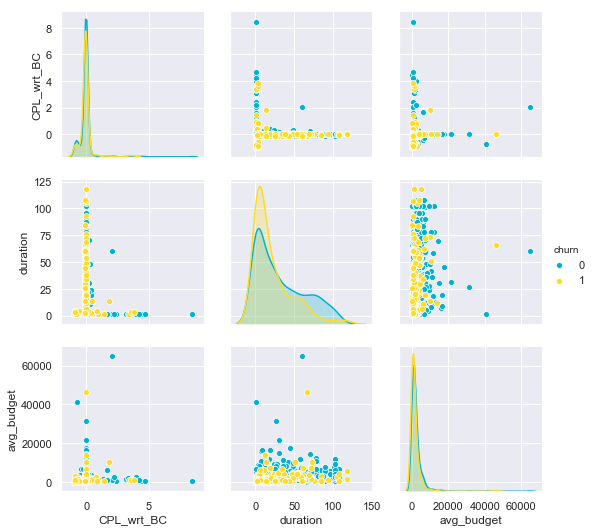

In [229]:
colors_ = ['#00B1D2FF','#FDDB27FF']
df_mis = df_churn[df_churn['CPL_wrt_self'].isnull()] #Making a df of NULL values measurements
num_cols = df_mis.select_dtypes(exclude='object')
del num_cols['CPL_wrt_self'] # Let's don't focus on it as of now
sns.pairplot(data=num_cols,vars= ['CPL_wrt_BC','duration','avg_budget'],hue='churn',palette =colors_)

From above scatter plots, there is no particular pattern emerging for any of the two target varibles.To decide whether we need to go for Imputation or Removal Data, the next thing we can analyze is coorelation plot.

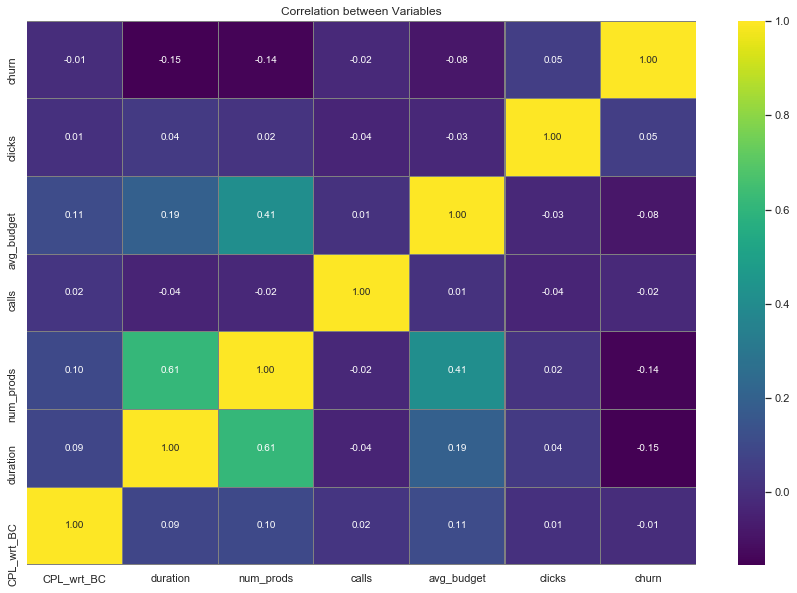

In [230]:
corr_quant = num_cols.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_quant, annot=True, cmap = 'viridis', linewidths = .1, linecolor = 'grey', fmt=".2f")
ax.invert_yaxis()
ax.set_title("Correlation between Variables")
plt.show()

In [231]:
df_mis.churn.value_counts()

0    839
1    253
Name: churn, dtype: int64

###### To Impute or not Impute: That’s the Question<br>
There seems to be no significant coorelation among the numerical features themselves and with the target variable. The missing value for churn(253 of 2000) and retention(839 of 8000) are apporximately 10% of the individual population size and combine 10% of the entire population i.e. 1094. Now, the final stage of investigation will be what information we will be lossinf if we remove them.

In [232]:
df_churn_miss = df_churn[df_churn["CPL_wrt_self"].notnull()]
df_churn_miss.describe()

,CPL_wrt_BC,duration,num_prods,calls,CPL_wrt_self,avg_budget,clicks,churn
count,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000
mean,-0.070098,27.365514,1.232600,4.507970,0.602664,1425.823105,99.097665,0.196116
std,0.484358,24.815864,0.620199,2.861623,11.135854,3442.583249,31.670328,0.397079
min,-0.994590,1.000000,0.000000,0.000000,-1.000000,9.090909,13.000000,0.000000
25%,-0.103075,7.000000,1.000000,2.000000,-0.255226,468.063508,76.000000,0.000000
50%,-0.090281,19.000000,1.000000,4.000000,0.000000,875.498247,96.000000,0.000000
75%,-0.060117,41.000000,1.000000,7.000000,0.311280,1576.185894,118.000000,0.000000
max,19.088412,118.000000,7.000000,9.000000,841.288094,148555.594376,253.000000,1.000000


In [233]:
df_churn[df_churn["num_prods"]>7]

,CPL_wrt_BC,client_state,duration,num_prods,calls,CPL_wrt_self,avg_budget,BC,clicks,churn
4490,0.0,CA,92,8,3,NaN,2518.568582,Dentists & Dental Services,109,0
5546,0.0,IL,102,10,0,NaN,11912.050604,Business Services,100,0
7030,0.0,FL,79,8,6,NaN,6233.122425,Dentists & Dental Services,202,0
8581,0.0,CO,96,9,1,NaN,3360.460772,Dentists & Dental Services,80,0
8664,0.0,NY,102,11,0,NaN,5947.710883,Apparel / Fashion & Jewelry,99,0
9524,0.0,IL,78,8,7,NaN,10533.324203,Business Services,117,0


##### What information we have lost
1.If we see 'num_prods' the maximum and mean has changed that means we have lost information for the client who had number of products greater than 7 and all of them belong to retention category.<br><br>
Since, we have to predict if we client will stop running Advertising campaigns. These datapoints will not make much difference. Finally, we can delete them.

### <span style="color:,tomato">3. Exploratory Data Analysis</span>

#### 3.1 Distribution of Target Variable

Text(0.5,1,'Distribution of Target Variable')

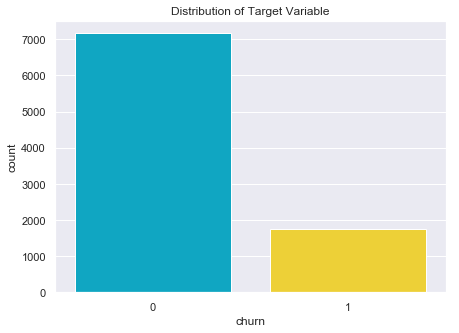

In [339]:
df_churn = df_churn_miss
sns.set(rc={'figure.figsize':(7,5)})
sns.countplot(x="churn",data=df_churn , palette=colors_, saturation=0.85).set_title('Distribution of Target Variable')

We see the inherent class imbalance in the dataset.<br><br>

##### 3.2 Distribution of numeric columns

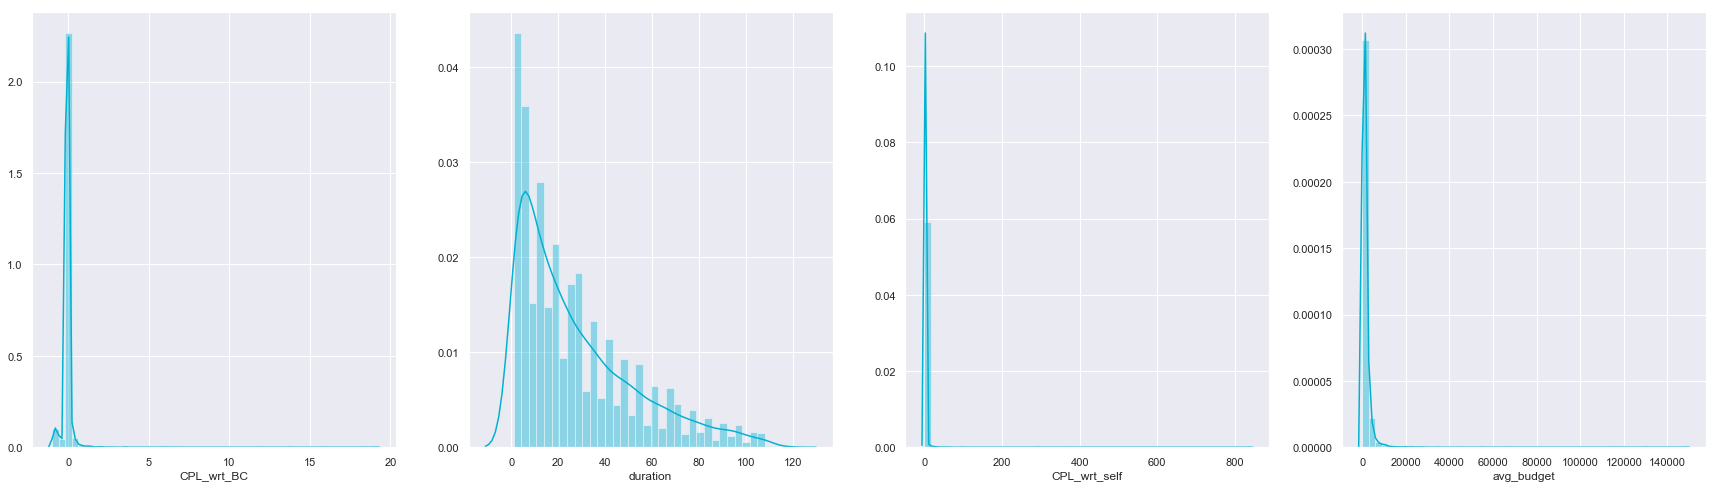

In [110]:
num_cols = ['CPL_wrt_BC', 'duration','CPL_wrt_self','avg_budget']
f, axes = plt.subplots(nrows=1,ncols=len(num_cols), squeeze=True,figsize=(30, 8))
for i,col in enumerate(num_cols):
    sns.distplot(df_churn[col], ax=axes[i],color = colors_[0])

##### 3.3 Checking distribution between numeric columns and Churn

In [145]:
def plot_distNum(cat):
    g = sns.FacetGrid(df_churn, hue="churn", height=8, palette=colors_, aspect=2, legend_out=True)
    g = (g.map(sns.distplot, cat, bins=np.arange(-2, 100), kde=False).add_legend())

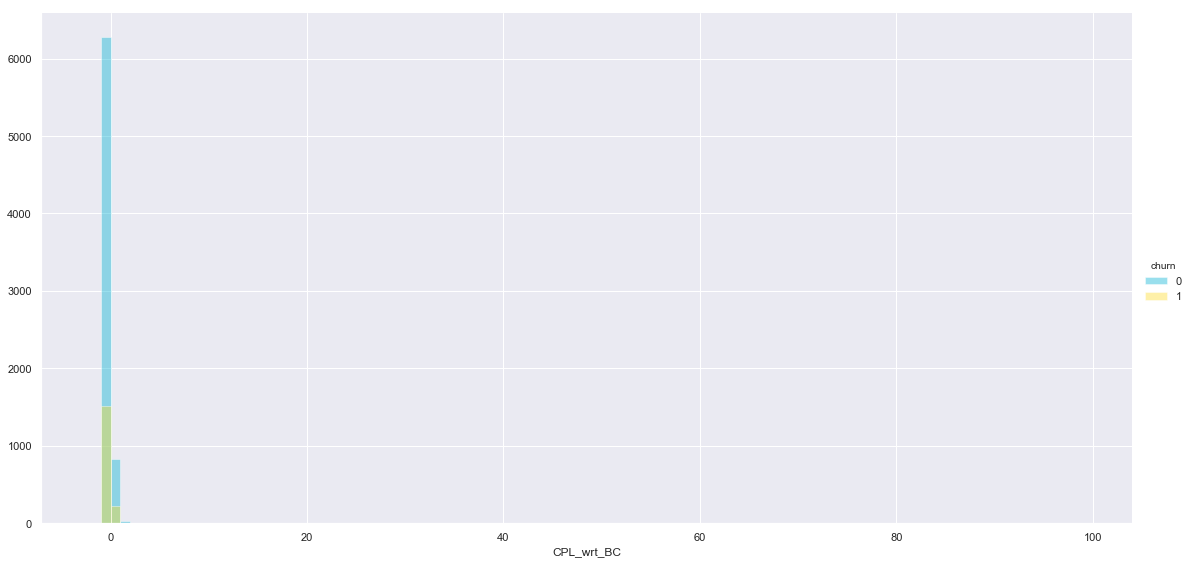

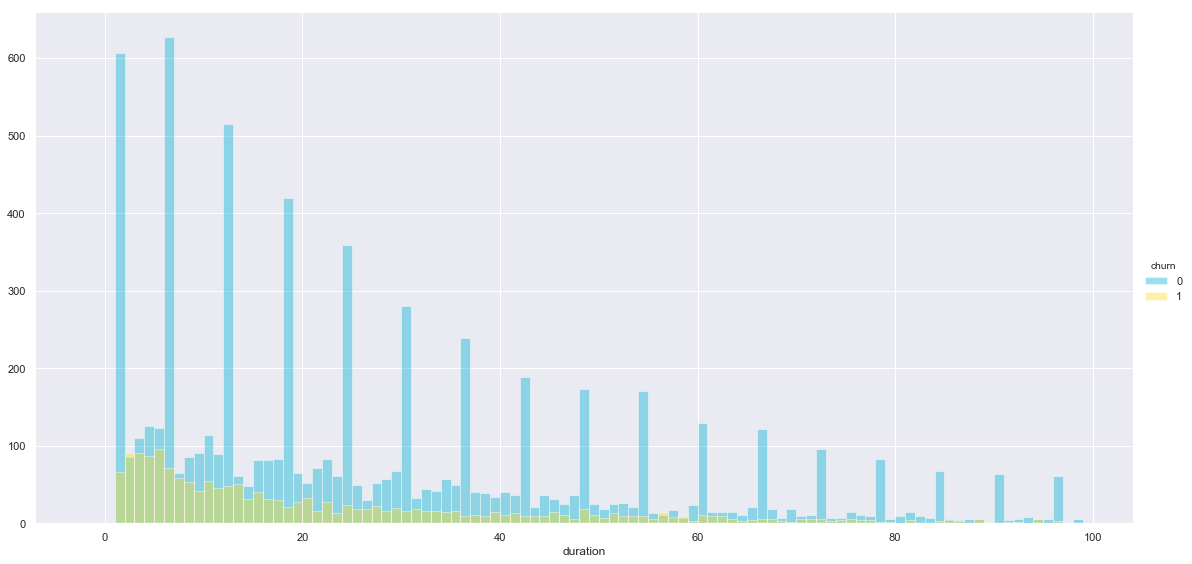

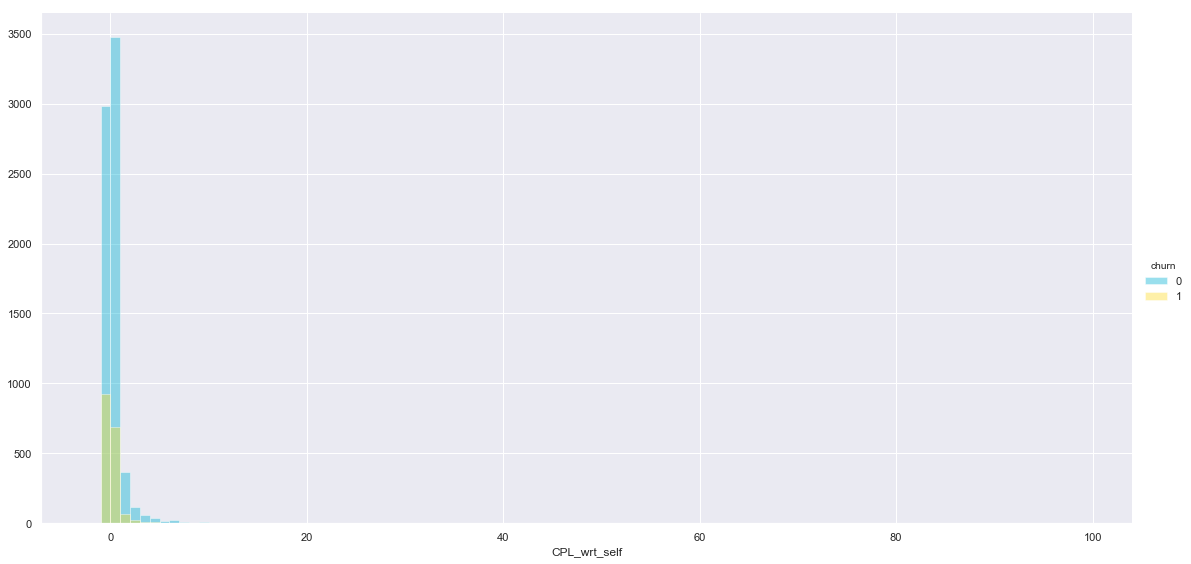

In [147]:
for i in num_cols[:-1]:
    plot_distNum(i)

##### Observations:
1. CPL_wrt_BC have more negative values.
2. The more duration is client with Ganett the less likely they are going to leave.
3. CPL_wrt_self is having more postive values which means there is an increase in cost per lead over the past three months.
<br><br>
##### 3.3.1 Average Budget

Text(0.5,1,'Upper Half')

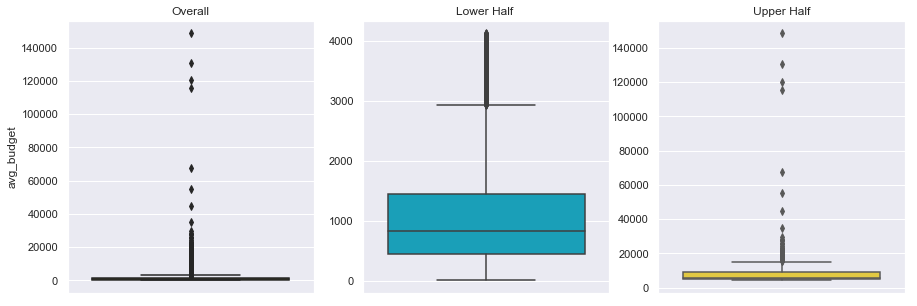

In [205]:
f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.boxplot(x=df_churn["avg_budget"], orient="v", color="olive",ax=axes[0]).set_title('Overall')
dflower = sorted(df_churn["avg_budget"].tolist())[:8500] # To better visualize 
dfupper = sorted(df_churn["avg_budget"].tolist())[8500:]
sns.boxplot(x=dflower, orient="v", color=colors_[0], ax=axes[1]).set_title('Lower Half ')
sns.boxplot(x=dfupper , orient="v", color=colors_[1], ax=axes[2]).set_title('Upper Half')

As per our intial obervations, since mean and median were having huge difference we were expecting such type of pattern with more outliers. We need to normalize our dataset so that model don't put too much weight on this feature.

##### 3.4 Checking realtionship between CPL_wrt_BC and BC

In [216]:
df_t = df_churn.groupby('BC', as_index=False)['CPL_wrt_BC'].mean()

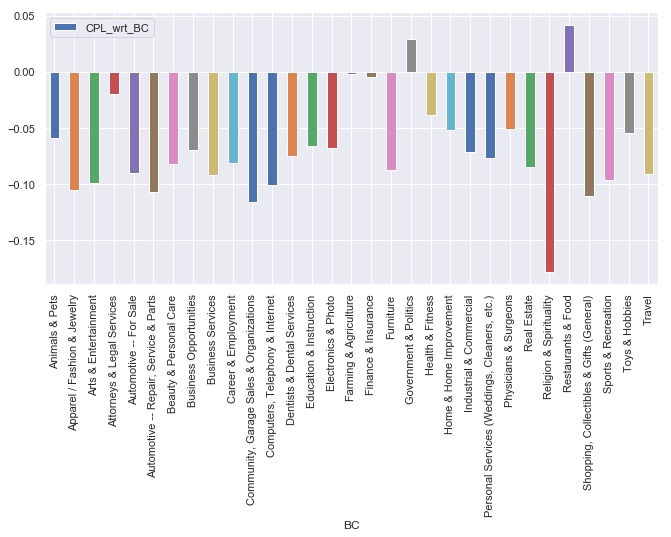

In [217]:
df_t.plot(x="BC", y='CPL_wrt_BC', kind="bar", figsize =(11,5))

##### Observation:
1. For Goverment & Politics and Restaurants & Food it has positve mean. 
2. Religious & Spirituality has most negative mean. 

##### 3.5 Checking realtionship between CPL_wrt_BC and client_state

In [218]:
df_t = df_churn.groupby('client_state', as_index=False)['CPL_wrt_BC'].mean()

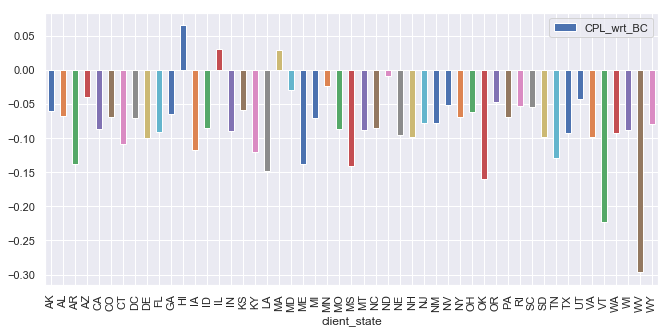

In [219]:
df_t.plot(x='client_state', y='CPL_wrt_BC', kind="bar", figsize =(11,5))

##### Observation:
1. Georgia, Illinois and Massachusetts have postive mean which will interesting to see further.
2. West Virginia has a negative mean.

### <span style="color:,tomato">4. Data Pre-Processing</span>

In [340]:
obj_ = df_churn.select_dtypes(include='object')
num_ = df_churn.select_dtypes(exclude='object')

##### 4.1 One-Hot Encoding 

In [341]:
df_churn=pd.get_dummies(data = df_churn,columns =  obj_.columns, drop_first=True)
df_churn.describe()

,CPL_wrt_BC,duration,num_prods,calls,CPL_wrt_self,avg_budget,clicks,churn,client_state_AL,client_state_AR,...,BC_Industrial & Commercial,"BC_Personal Services (Weddings, Cleaners, etc.)",BC_Physicians & Surgeons,BC_Real Estate,BC_Religion & Spirituality,BC_Restaurants & Food,"BC_Shopping, Collectibles & Gifts (General)",BC_Sports & Recreation,BC_Toys & Hobbies,BC_Travel
count,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,...,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000
mean,-0.070098,27.365514,1.232600,4.507970,0.602664,1425.823105,99.097665,0.196116,0.004939,0.002021,...,0.028738,0.048608,0.047036,0.029187,0.001010,0.011675,0.078244,0.024697,0.002582,0.053211
std,0.484358,24.815864,0.620199,2.861623,11.135854,3442.583249,31.670328,0.397079,0.070111,0.044909,...,0.167079,0.215059,0.211729,0.168341,0.031771,0.107424,0.268571,0.155208,0.050750,0.224466
min,-0.994590,1.000000,0.000000,0.000000,-1.000000,9.090909,13.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.103075,7.000000,1.000000,2.000000,-0.255226,468.063508,76.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.090281,19.000000,1.000000,4.000000,0.000000,875.498247,96.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-0.060117,41.000000,1.000000,7.000000,0.311280,1576.185894,118.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,19.088412,118.000000,7.000000,9.000000,841.288094,148555.594376,253.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### 4.2 Normalization

In [373]:
scale = StandardScaler()
scale.fit_transform(num_)
scaled_feat = scale.transform(num_)
df_churn_scaled = pd.DataFrame(scaled_feat, columns= num_.columns)
df_churn_scaled = pd.concat([df_churn_scaled[['duration','avg_budget','CPL_wrt_BC','CPL_wrt_self','num_prods','clicks','calls']], df_churn.drop(['duration','avg_budget','CPL_wrt_BC','CPL_wrt_self','num_prods','clicks','calls'], axis=1)], axis=1)

In [374]:
df_churn_scaled = df_churn_scaled.dropna(how='any',axis=0) #Some of the records don't have client state information or business info
df_churn_scaled.churn.value_counts()

0.0    6349
1.0    1582
Name: churn, dtype: int64

In [375]:
df_churn_scaled.describe()

,duration,avg_budget,CPL_wrt_BC,CPL_wrt_self,num_prods,clicks,calls,churn,client_state_AL,client_state_AR,...,BC_Industrial & Commercial,"BC_Personal Services (Weddings, Cleaners, etc.)",BC_Physicians & Surgeons,BC_Real Estate,BC_Religion & Spirituality,BC_Restaurants & Food,"BC_Shopping, Collectibles & Gifts (General)",BC_Sports & Recreation,BC_Toys & Hobbies,BC_Travel
count,7931.000000,7931.000000,7931.000000,7931.000000,7931.000000,7931.000000,7931.000000,7931.000000,7931.000000,7931.000000,...,7931.000000,7931.000000,7931.000000,7931.000000,7931.000000,7931.000000,7931.000000,7931.000000,7931.000000,7931.000000
mean,0.002389,0.002056,0.003148,0.002865,-0.004829,-0.004565,0.001026,0.199470,0.005044,0.002143,...,0.030135,0.049678,0.047409,0.028244,0.001009,0.011726,0.076787,0.024713,0.002648,0.052705
std,1.001396,1.043214,1.024070,1.058029,0.993252,0.998445,0.999732,0.399627,0.070843,0.046251,...,0.170969,0.217294,0.212525,0.165678,0.031746,0.107657,0.266270,0.155259,0.051392,0.223457
min,-1.062506,-0.411555,-1.908804,-0.143927,-1.987537,-2.718712,-1.575408,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.820711,-0.278331,-0.068149,-0.076900,-0.375062,-0.729357,-0.876464,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.337122,-0.159370,-0.041801,-0.054122,-0.375062,-0.097815,0.171950,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.549457,0.043501,0.020450,-0.026474,-0.375062,0.596880,0.870894,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.652485,42.740587,39.556692,75.497813,9.299790,4.859785,1.569837,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [849]:
df_churn_scaled.head()

,duration,avg_budget,CPL_wrt_BC,CPL_wrt_self,num_prods,clicks,calls,churn,client_state_AL,client_state_AR,...,BC_Industrial & Commercial,"BC_Personal Services (Weddings, Cleaners, etc.)",BC_Physicians & Surgeons,BC_Real Estate,BC_Religion & Spirituality,BC_Restaurants & Food,"BC_Shopping, Collectibles & Gifts (General)",BC_Sports & Recreation,BC_Toys & Hobbies,BC_Travel
1,3.007700,0.728911,0.161054,-0.080346,1.237414,-0.287278,1.220365,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.861010,-0.280121,-0.071856,-0.001388,-0.375062,0.407418,0.171950,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.267364,-0.322775,0.117773,-0.139916,-0.375062,-0.129392,0.521422,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.040523,0.096794,-0.061529,-0.076224,-0.375062,-0.224123,-0.876464,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.798728,-0.060575,-0.057472,-0.044120,1.237414,-0.255701,-1.225936,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [851]:
cols = df_churn_scaled.columns
cols = [x for x in cols if "churn" not in x]
cols

['duration',
 'avg_budget',
 'CPL_wrt_BC',
 'CPL_wrt_self',
 'num_prods',
 'clicks',
 'calls',
 'client_state_AL',
 'client_state_AR',
 'client_state_AZ',
 'client_state_CA',
 'client_state_CO',
 'client_state_CT',
 'client_state_DC',
 'client_state_DE',
 'client_state_FL',
 'client_state_GA',
 'client_state_HI',
 'client_state_IA',
 'client_state_ID',
 'client_state_IL',
 'client_state_IN',
 'client_state_KS',
 'client_state_KY',
 'client_state_LA',
 'client_state_MA',
 'client_state_MD',
 'client_state_ME',
 'client_state_MI',
 'client_state_MN',
 'client_state_MO',
 'client_state_MS',
 'client_state_MT',
 'client_state_NC',
 'client_state_ND',
 'client_state_NE',
 'client_state_NH',
 'client_state_NJ',
 'client_state_NM',
 'client_state_NV',
 'client_state_NY',
 'client_state_OH',
 'client_state_OK',
 'client_state_OR',
 'client_state_PA',
 'client_state_RI',
 'client_state_SC',
 'client_state_SD',
 'client_state_TN',
 'client_state_TX',
 'client_state_UT',
 'client_state_VA',
 'cli

##### 4.3 Coorelation Plot

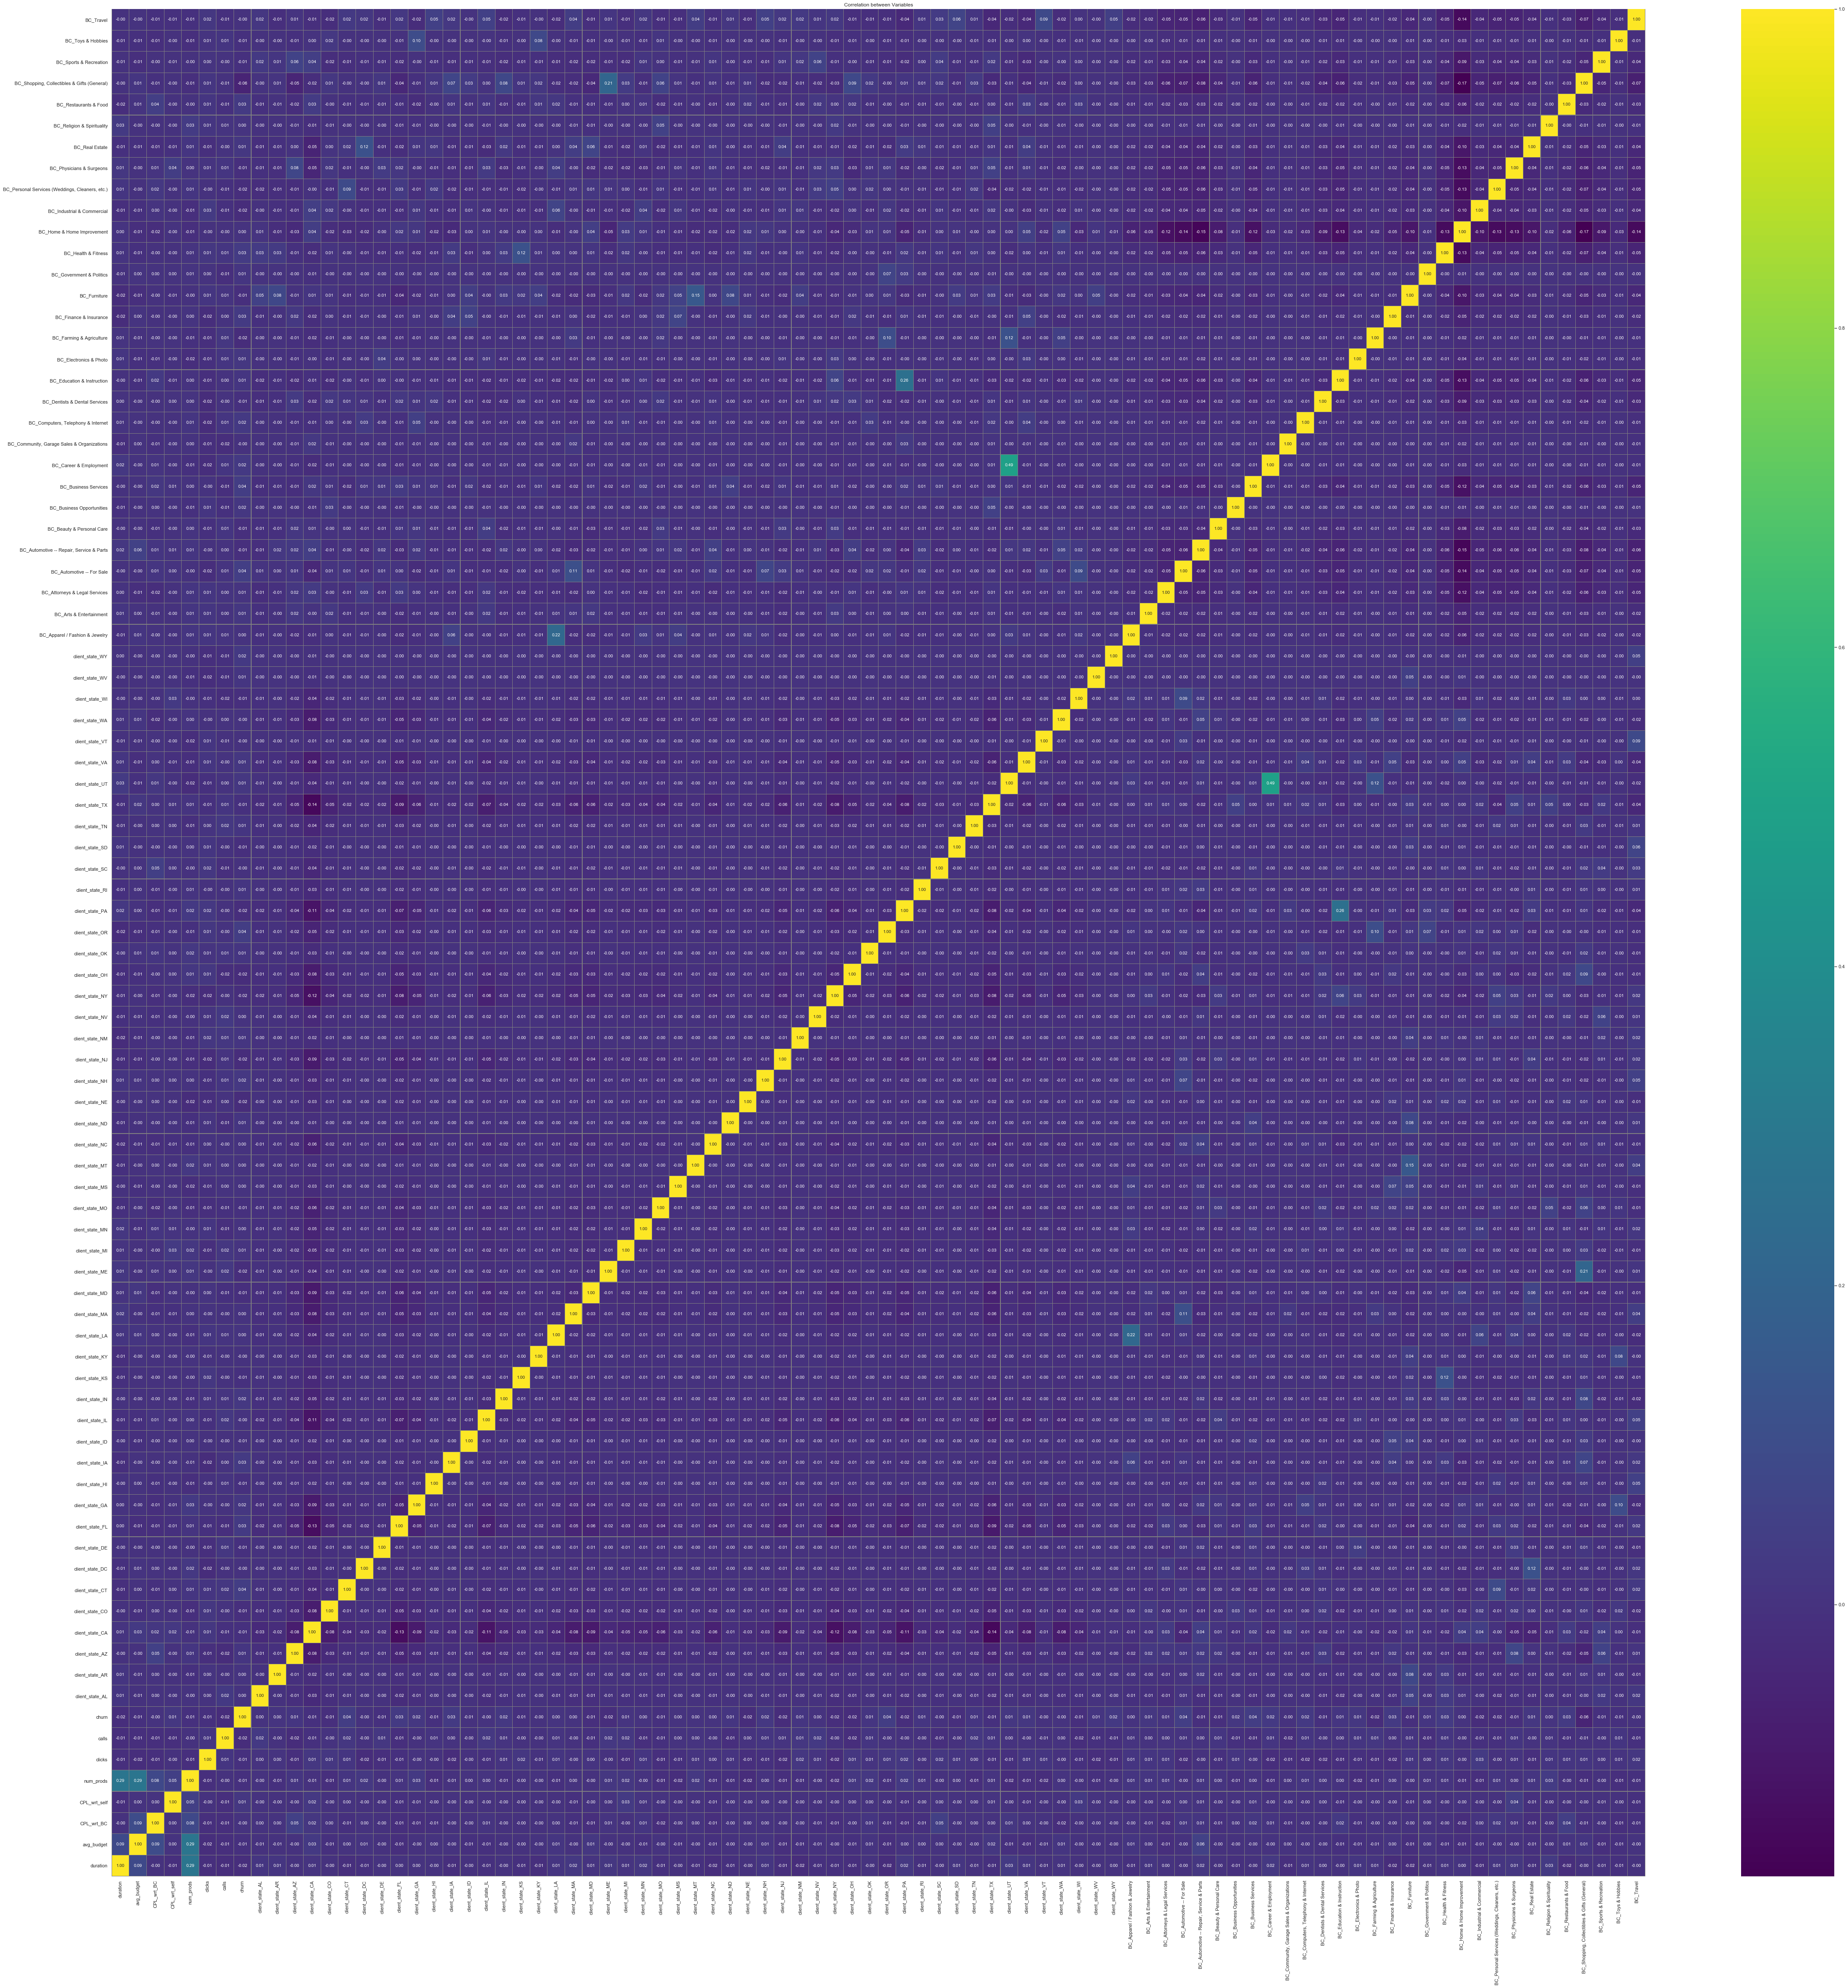

In [836]:
corr_quant = df_churn_scaled.corr()
fig, ax = plt.subplots(figsize=(80, 80))
ax = sns.heatmap(corr_quant, annot=True, cmap = 'viridis', linewidths = .1, linecolor = 'grey', fmt=".2f")
ax.invert_yaxis()
ax.set_title("Correlation between Variables")
plt.show()

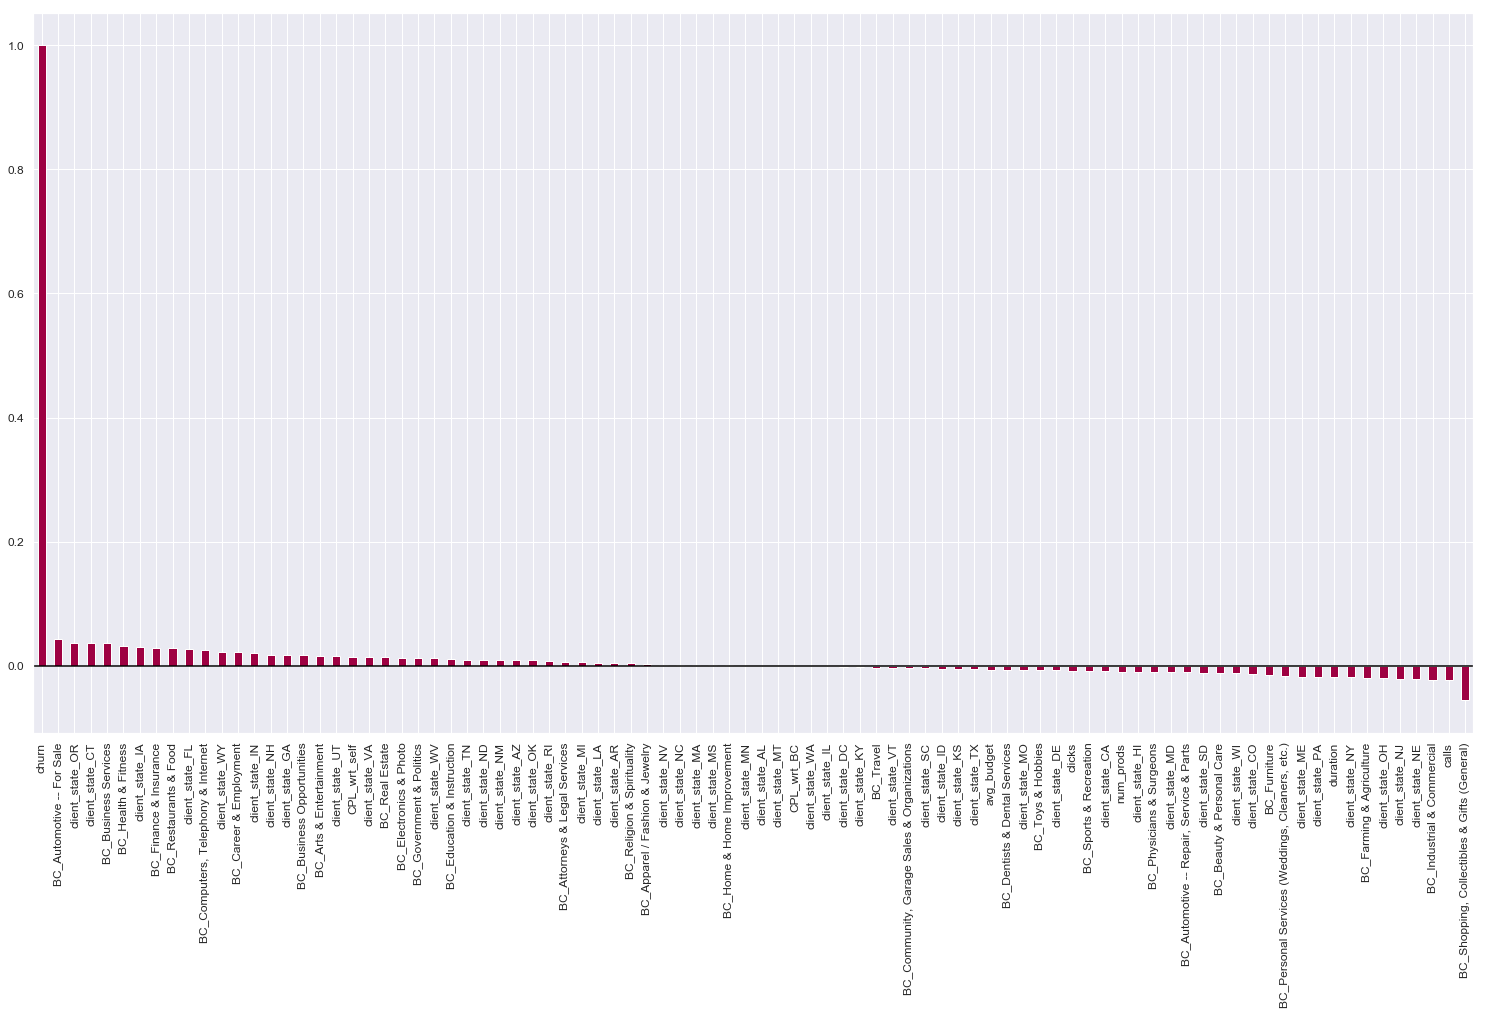

In [364]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
df_churn_scaled.corr()['churn'].sort_values(ascending = False).plot(kind='bar', cmap="Spectral")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
ax.axhline(0, color='black')    
total=len(df_churn_scaled.corr()['churn'])

##### Obsevations:
1. 'Calls' and 'Duration' are negatively coorelated to churn.
2. 'Automotive - For Sale' and 'CPL_wrt_Self' category is positve coorelated to churn.
3. 'CPL_wrt_BC' seems to be neither positve or negatively.

### <span style="color:,tomato">5. Model Training</span>
I will be using following models:
    1. Logistic Regression
    2. Linear SVC (Liblinear)
    3. Linear SVM with SGD
    4. Random Forest
    5. Neural Network
    
To evaluate models I will be focusing more on Precision which will answer of all the users that the model predicts will churn, how many of them do actually churn?. I think it's important to understand different situations where we care about Precision and Recall. To get an understanfing let's take an example

Consider a situation in which you are going to send an email like this “We noticed you may be leaving us. Please don’t”. In such situation, Precision is prefered over recall since you want to minimize number of happy user's seeing this email.

On the other hand, consider an offer email for example USA today is offering 5% discount on monthly subscription.  In this situation I won't be worried about customers who are happy receving it. Ideally,I will want anyone who might churn to see the email. In this case, you would want your recall to be higher than your precision.



In [850]:
train_x, valid_x, train_y, valid_y = train_test_split(df_churn_scaled.drop(['churn'],axis=1),df_churn_scaled['churn'],test_size=0.20)

In [380]:
# Logistic Regression
logi = linear_model.LogisticRegression(penalty="l2")
logi.fit(train_x, train_y)
predictions = logi.predict(valid_x)
print(classification_report(valid_y, predictions))

             precision    recall  f1-score   support

        0.0       0.81      1.00      0.89      1282
        1.0       0.00      0.00      0.00       305

avg / total       0.65      0.81      0.72      1587



/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [417]:
#Random Forest
rf = ensemble.RandomForestClassifier(n_estimators=2000, random_state=14128, verbose=True)
rf.fit(train_x, train_y)
predictions = rf.predict(valid_x)
print(classification_report(valid_y, predictions))

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   19.3s finished


             precision    recall  f1-score   support

        0.0       0.81      1.00      0.89      1282
        1.0       0.00      0.00      0.00       305

avg / total       0.65      0.81      0.72      1587



[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.7s finished


<br>
##### Something is wrong. What's happening?<br><br>
The model is only predicting majority class. It's incapable of differentiating between the two classes.The reason is the imbalanced data.<br><br>
There are primary two ways to handle imbalanced data:<br>
1. Undersampling
2. Oversampling<br><br>

#### 5.1 Oversampling: SMOTE (Synthetic Minority Oversampling Technique) and ADASYN (Adaptive Synthetic Sampling Approach)<br><br>
I will be focusing on Oversampling for this problem as want to use all the information that is available.

##### 5.1.1 SMOTE

In [852]:
smote_ = SMOTE(sampling_strategy='auto',k_neighbors=3,random_state=1)
X_samp = train_x.as_matrix()
y_samp = train_y.as_matrix()
X_train_res, y_train_res = smote_.fit_sample(X_samp, y_samp)

In [853]:
def train_model(classifier, train_x, train_y, valid_x, valid_y,rf_flag):
    classifier.fit(train_x, train_y)
    predictions = classifier.predict(valid_x)
    print(classification_report(valid_y, predictions))
    print("AUC-ROC Score:\t"+ str(roc_auc_score(valid_y, predictions)))
    print("----- Confusion Matrix ------")
    cm=confusion_matrix(valid_y,predictions)
    plt.figure(figsize = (10,5))
    sns.set_context(font_scale=5)
    df_cm = pd.DataFrame(cm, index = ['Retention','Churn'],columns = ['Retention','Churn'])
    sns.heatmap(df_cm, annot=True, cmap='Blues')
    print(confusion_matrix(valid_y, predictions))
    if not rf_flag:
        coef_  = pd.DataFrame(classifier.coef_.ravel())
        dfc     = pd.DataFrame(cols)
        f_sumry    = (pd.merge(coef_,dfc,left_index= True,right_index= True, how = "left"))
        f_sumry.columns = ['coefficients','features']
        f_sumry    = f_sumry.sort_values(by = 'coefficients',ascending = False)
        f_sumry.plot(x='features', y='coefficients', kind='bar', figsize =(20,10),title='Fetaure Importance')

             precision    recall  f1-score   support

        0.0       0.82      0.56      0.67      1279
        1.0       0.22      0.51      0.30       308

avg / total       0.71      0.55      0.59      1587

AUC-ROC Score:	0.5319801387041418
----- Confusion Matrix ------
[[713 566]
 [152 156]]


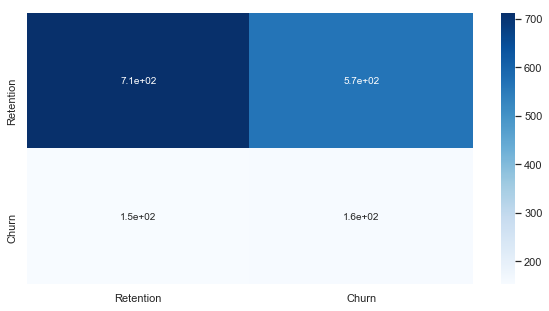

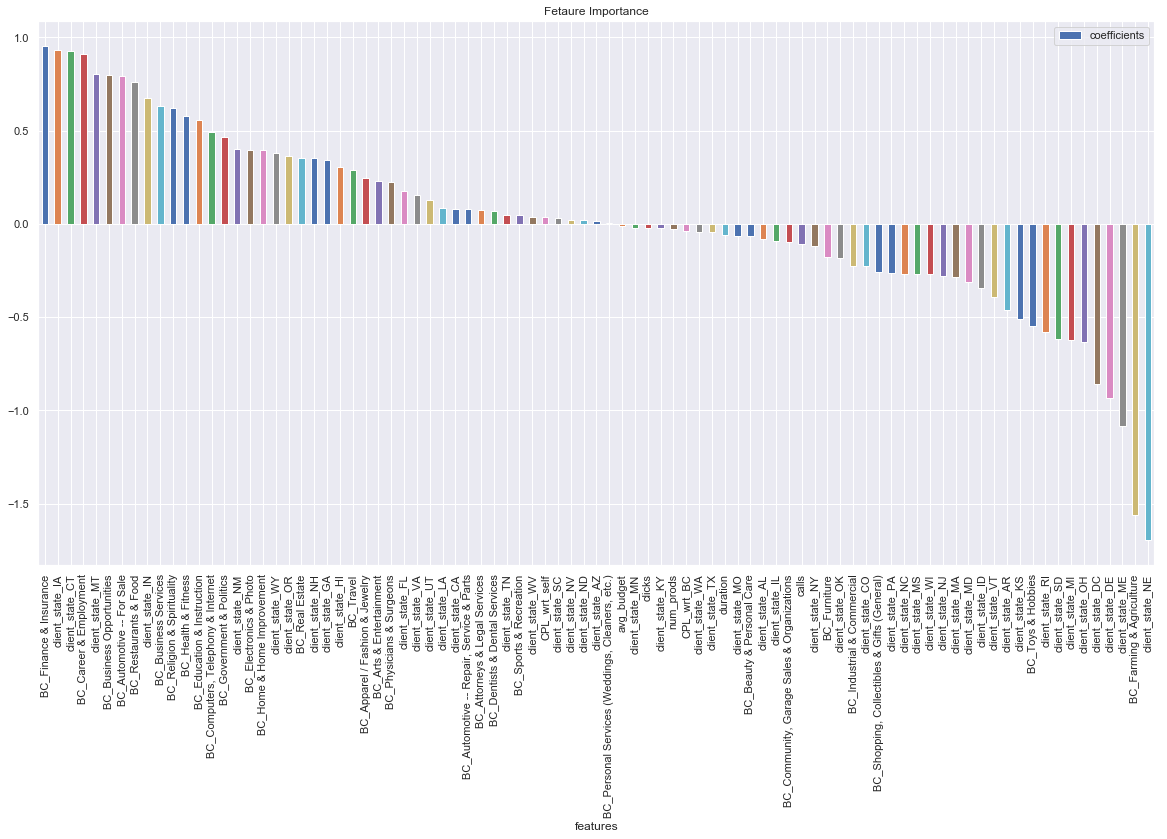

In [854]:
# Logistic Regression
train_model(linear_model.LogisticRegression(penalty="l2"),X_train_res, y_train_res, valid_x,valid_y,False)

             precision    recall  f1-score   support

        0.0       0.83      0.48      0.61      1279
        1.0       0.22      0.60      0.32       308

avg / total       0.71      0.50      0.55      1587

AUC-ROC Score:	0.5395740889290538
----- Confusion Matrix ------
[[612 667]
 [123 185]]


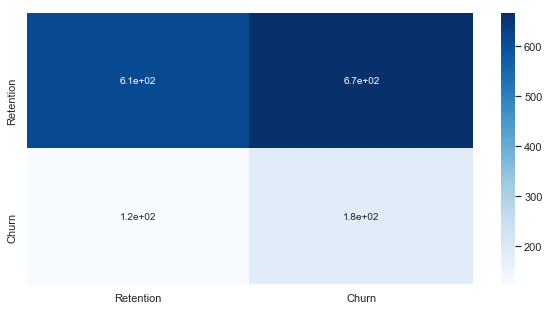

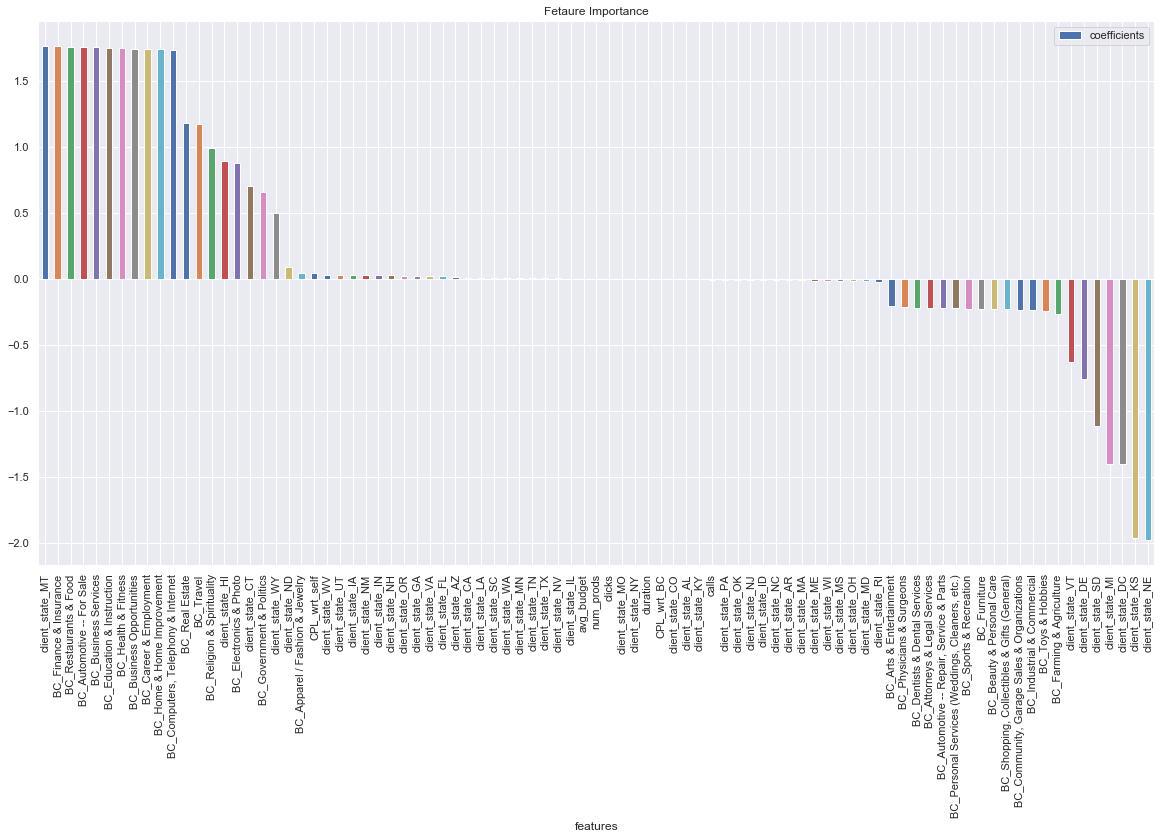

In [855]:
# Linear SVC
train_model(svm.SVC(kernel='linear', C = 0.5),X_train_res, y_train_res, valid_x,valid_y,False)

             precision    recall  f1-score   support

        0.0       0.82      0.55      0.66      1279
        1.0       0.22      0.51      0.30       308

avg / total       0.71      0.54      0.59      1587

AUC-ROC Score:	0.5308670024268148
----- Confusion Matrix ------
[[706 573]
 [151 157]]


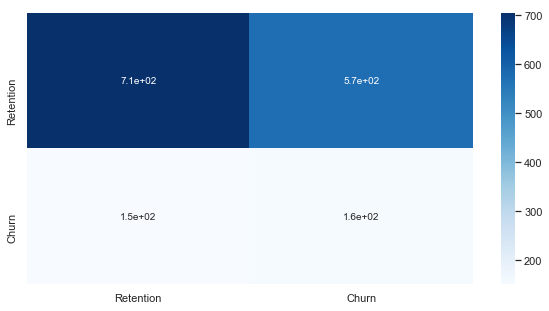

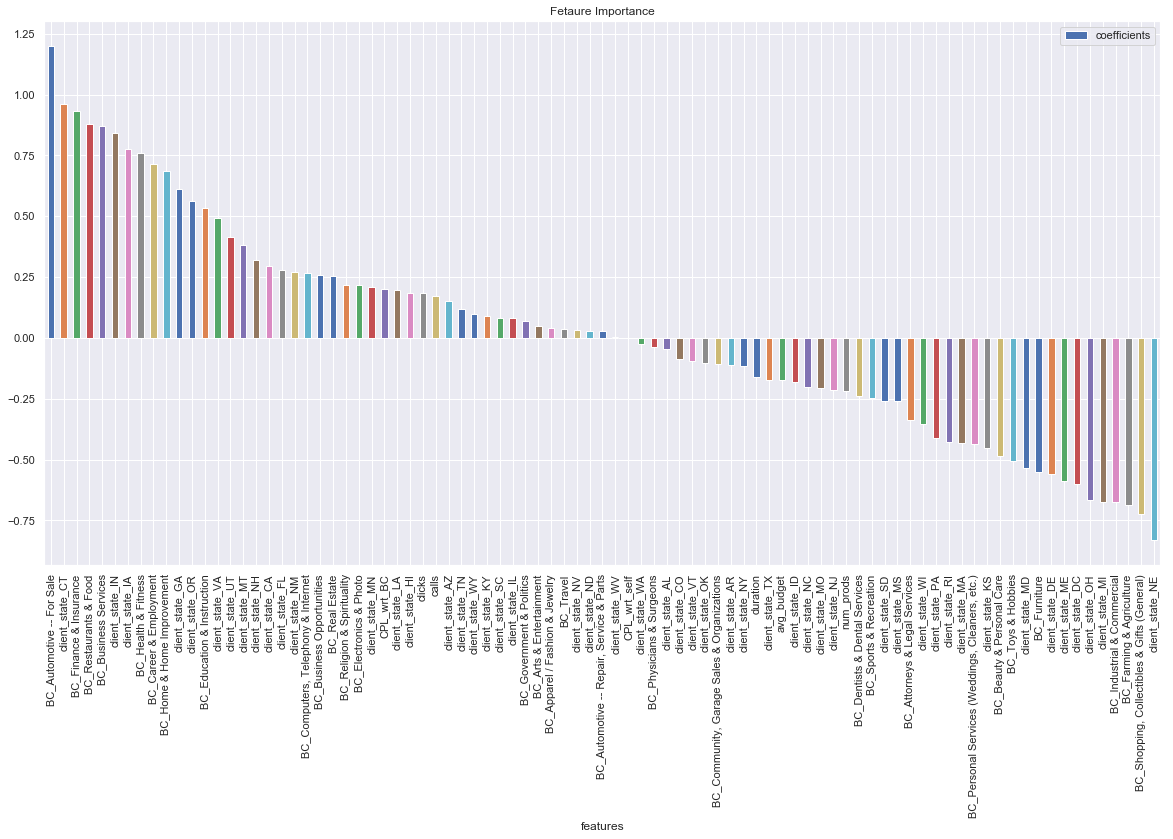

In [856]:
# SGD Classfier
train_model(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5),X_train_res, y_train_res, valid_x,valid_y,False)

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.5s finished


             precision    recall  f1-score   support

        0.0       0.81      0.95      0.87      1279
        1.0       0.27      0.08      0.12       308

avg / total       0.71      0.78      0.73      1587

AUC-ROC Score:	0.5143920778205376
----- Confusion Matrix ------
[[1212   67]
 [ 283   25]]


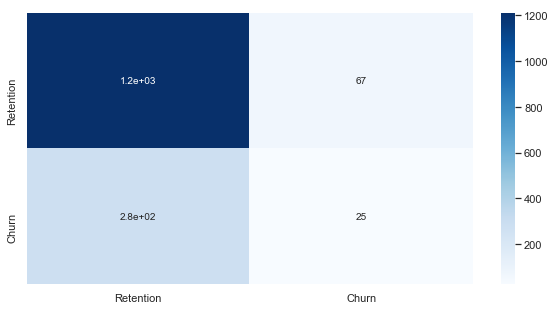

In [857]:
# Random Forest
train_model(ensemble.RandomForestClassifier(n_estimators=1000, random_state=14128, verbose=True),X_train_res, y_train_res, valid_x,valid_y,True)

<br>
##### 5.1.2 ADASYN

In [858]:
adasyn_ = ADASYN(sampling_strategy='auto',n_neighbors=5,random_state=1)
X_samp = train_x.as_matrix()
y_samp = train_y.as_matrix()
X_train_res, y_train_res = adasyn_.fit_sample(X_samp, y_samp)

             precision    recall  f1-score   support

        0.0       0.82      0.54      0.65      1279
        1.0       0.21      0.51      0.30       308

avg / total       0.70      0.54      0.58      1587

AUC-ROC Score:	0.5274082836631704
----- Confusion Matrix ------
[[693 586]
 [150 158]]


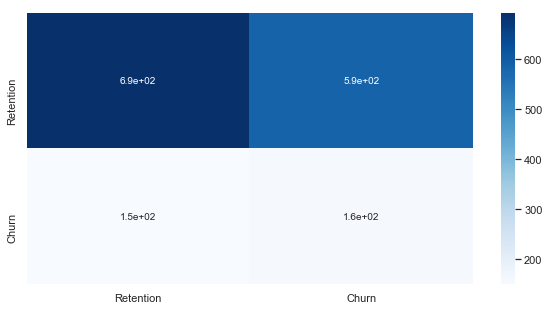

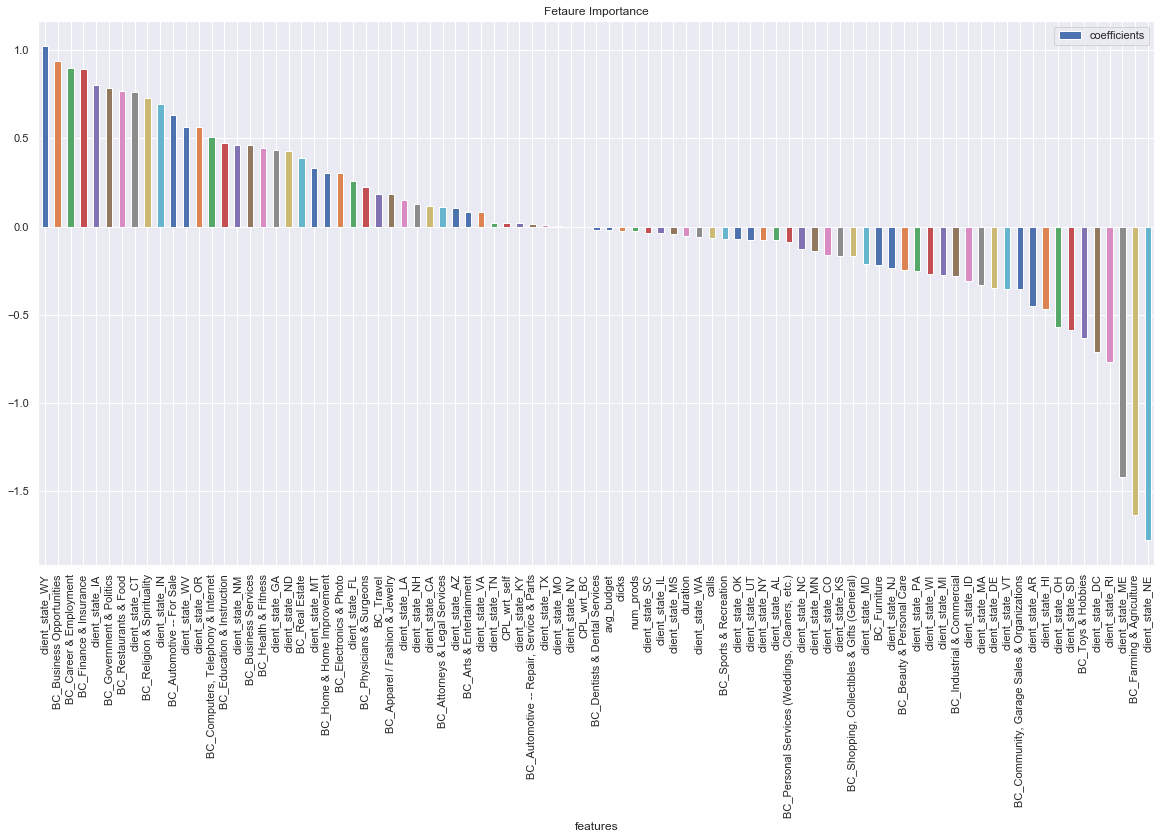

In [859]:
# Logistic Regression
train_model(linear_model.LogisticRegression(penalty="l2"),X_train_res, y_train_res, valid_x,valid_y,False)

             precision    recall  f1-score   support

        0.0       0.83      0.47      0.60      1279
        1.0       0.21      0.60      0.32       308

avg / total       0.71      0.49      0.54      1587

AUC-ROC Score:	0.5344919935420326
----- Confusion Matrix ------
[[599 680]
 [123 185]]


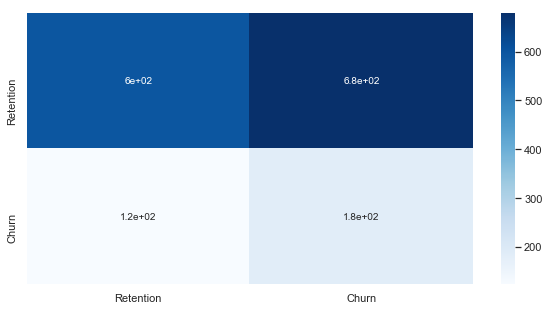

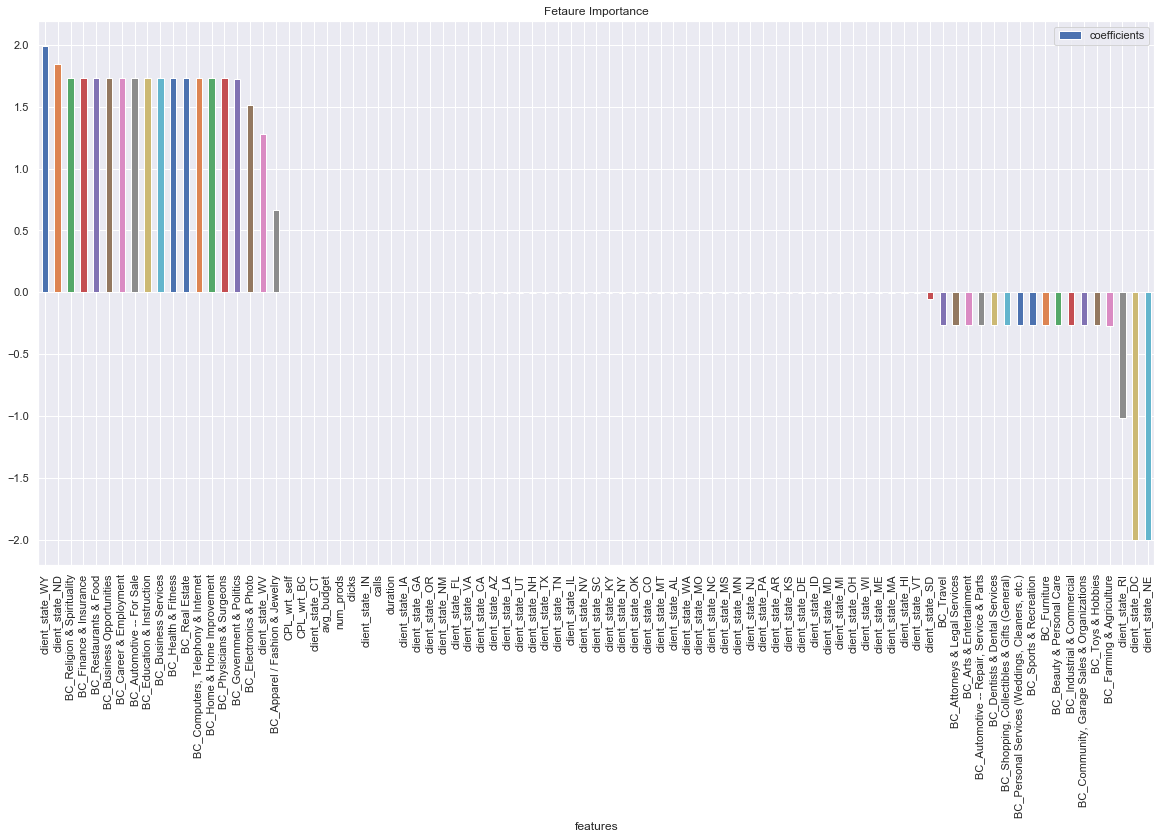

In [860]:
# Linear SVC
train_model(svm.SVC(kernel='linear', C = 0.75),X_train_res, y_train_res, valid_x,valid_y,False)

             precision    recall  f1-score   support

        0.0       0.83      0.40      0.54      1279
        1.0       0.21      0.66      0.32       308

avg / total       0.71      0.45      0.50      1587

AUC-ROC Score:	0.5296421717453774
----- Confusion Matrix ------
[[516 763]
 [106 202]]


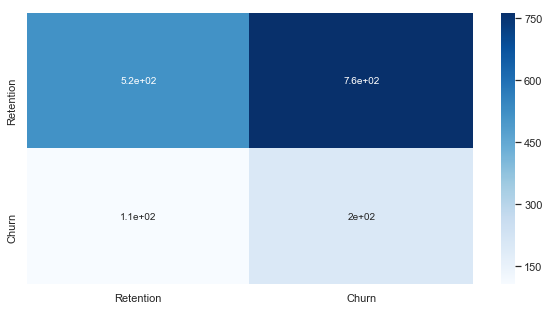

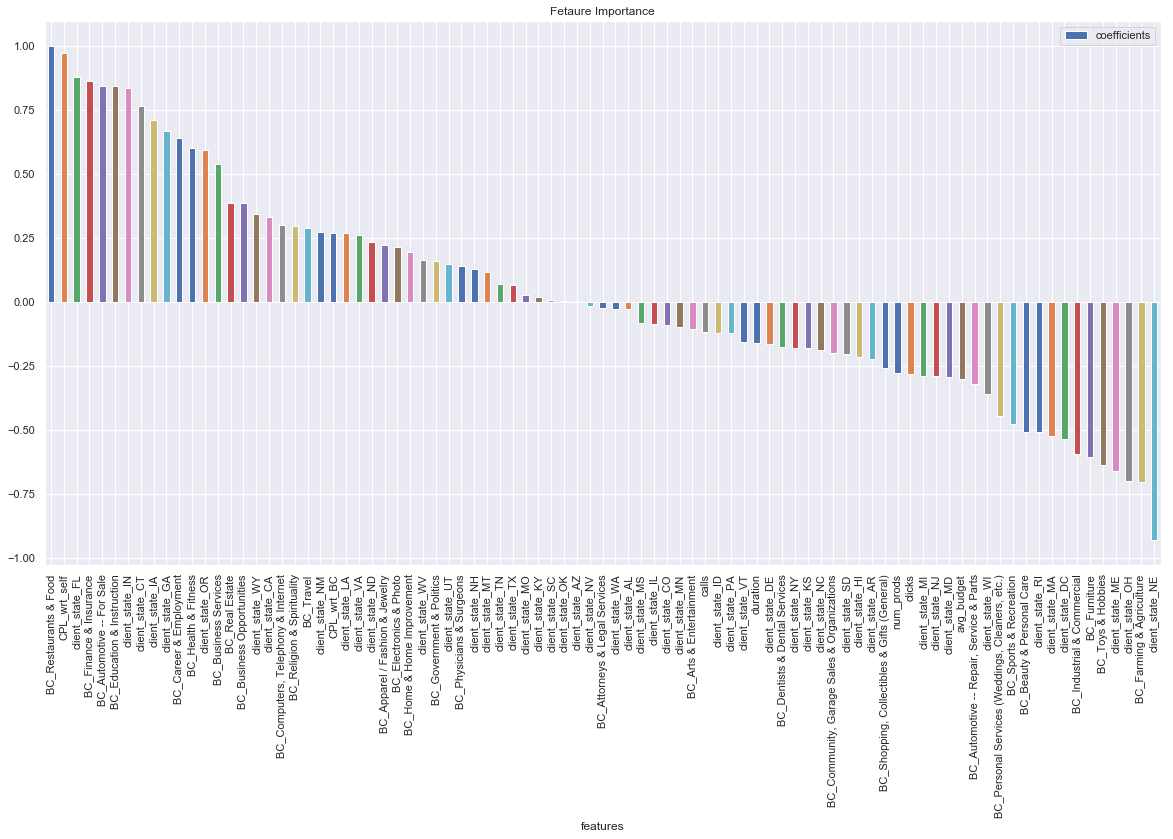

In [864]:
# SGD Classfier
train_model(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5),X_train_res, y_train_res, valid_x,valid_y,False)

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   16.0s finished
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished


             precision    recall  f1-score   support

        0.0       0.81      0.95      0.87      1282
        1.0       0.20      0.05      0.08       305

avg / total       0.69      0.78      0.72      1587

AUC-ROC Score:	0.5004884785555357
----- Confusion Matrix ------
[[1216   66]
 [ 289   16]]


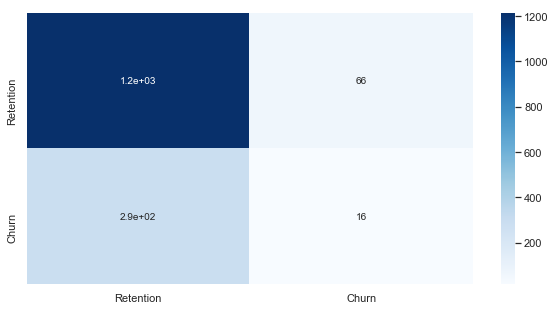

In [817]:
# Random Forest
train_model(ensemble.RandomForestClassifier(n_estimators=1000, random_state=14128, verbose=True),X_train_res, y_train_res, valid_x,valid_y,True)

None of the classifier has achieved a good precison, but SGD with ADASYN sampling technique has highest Recall for churn class. The data is demanding more complex models that can capture the representations within it. I will be looking for Neural Networks with ADASYN sampling texhnique.

#### 5.3 Neural Networks

In [670]:
# Sampling Data
ada = ADASYN(sampling_strategy='auto',n_neighbors=5,random_state=1)
X_ada,y_ada = ada.fit_sample(train_x,train_y)
X_ada = pd.DataFrame(data = X_ada,columns= df_churn_scaled.drop(['churn'], axis=1).columns)
y_ada  = pd.DataFrame(data = y_ada,columns=["churn"])
X_matrix_ada = X_ada.as_matrix()
y_matrix_ada = y_ada.as_matrix()
X_test,y_test = ada.fit_sample(valid_x,valid_y)
X_ada_test = pd.DataFrame(data = X_test,columns= df_churn_scaled.drop(['churn'], axis=1).columns)
y_ada_test  = pd.DataFrame(data = y_test,columns=["churn"])
X_matrix_ada_test = X_ada.as_matrix()
y_matrix_ada_test =y_ada.as_matrix()

In [689]:
# Model Building
n_cols=X_matrix_smote.shape[1]
model = Sequential()
model.add(Dense(32, input_shape=(n_cols,), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 32)                2816      
_________________________________________________________________
dense_97 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_98 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 9         
Total params: 3,489
Trainable params: 3,489
Non-trainable params: 0
_________________________________________________________________


In [702]:
history = model.fit(X_matrix_ada, y_matrix_ada, epochs=15, batch_size=16)

Epoch 1/15
10205/10205 [==============================] - 1s 86us/step - loss: 0.3264 - acc: 0.8542
Epoch 2/15
10205/10205 [==============================] - 1s 79us/step - loss: 0.2992 - acc: 0.8686
Epoch 3/15
10205/10205 [==============================] - 1s 78us/step - loss: 0.2918 - acc: 0.8669
Epoch 4/15
10205/10205 [==============================] - 1s 77us/step - loss: 0.2853 - acc: 0.8735
Epoch 5/15
10205/10205 [==============================] - 1s 77us/step - loss: 0.2786 - acc: 0.8760
Epoch 6/15
10205/10205 [==============================] - 1s 78us/step - loss: 0.2774 - acc: 0.8762
Epoch 7/15
10205/10205 [==============================] - 1s 78us/step - loss: 0.2751 - acc: 0.8815
Epoch 8/15
10205/10205 [==============================] - 1s 78us/step - loss: 0.2776 - acc: 0.8753
Epoch 9/15
10205/10205 [==============================] - 1s 95us/step - loss: 0.2691 - acc: 0.8812
Epoch 10/15
10205/10205 [==============================] - 1s 77us/step - loss: 0.2602 - acc: 0.8833

In [703]:
predictions   = model.predict(X_matrix_ada_test)
score = model.evaluate(X_matrix_ada_test, y_matrix_ada_test, verbose=1)

10205/10205 [==============================] - 0s 23us/step


             precision    recall  f1-score   support

        0.0       0.92      0.89      0.91      5067
        1.0       0.90      0.92      0.91      5138

avg / total       0.91      0.91      0.91     10205

AUC-ROC Score:	0.9093535875784534
---- Confusion Matrix -------
[[4533  534]
 [ 390 4748]]


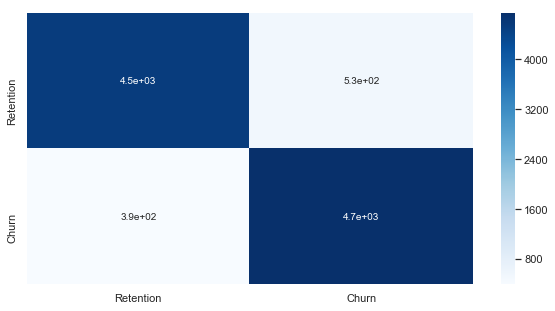

In [809]:
y_pred = (predictions > 0.5)
print(classification_report(y_matrix_ada_test, y_pred))
print("AUC-ROC Score:\t"+ str(roc_auc_score(y_matrix_ada_test, y_pred)))
print("---- Confusion Matrix -------")
cm=confusion_matrix(y_matrix_ada_test, y_pred)
plt.figure(figsize = (10,5))
sns.set_context(font_scale=5)
df_cm = pd.DataFrame(cm, index = ['Retention','Churn'],columns = ['Retention','Churn'])
sns.heatmap(df_cm, annot=True, cmap='Blues')
print(confusion_matrix(y_matrix_ada_test, y_pred))

From above we can see that we have achieved a precision of 90% for the churn class which is a good news. Since, from start we were looking for a model that has good precision for identifying churn class. Also, it has Fl-Score of 91% which is balancing the trade off between Precison and Recall.

#### Conclusion:

Various markets across the world are becoming increasingly more saturated, with more and more customers swapping their registered services between competing companies. Based on above experimentation, there seems to be traditionally machine learning methods falling back due to complexity of problem. We also saw how effective Neurals Networks can be when dealing with such sort of data and since churn prediction is the analysis of user behavioural patterns, the application of NNs in this domain could definitely be beneficial not only in terms of prediction accuracies but also in eliminating manual feature engineering as a required step.

##### <span style="color:,black">END</span>